## 0. Import Libraries

For ease of use and ram, run each indices in different sessions

In [1]:
import sys 
import time
import xarrayMannKendall

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

## 1. Data Options

In [9]:
# change these
season = 'DJF' # DJF, JJA,
time_resample = 1 # options: 1, 3, 6 (resampling)
heavy_rain = 4 * time_resample # 4mm times the resample period

# bias algorithm
bias_algo = 'QDM'

# path for resampling information
if time_resample != 1:
    path_resample = fr'{time_resample}hrsum'
else:
    path_resample = fr'{time_resample}hr'
    
# general data path
path_general = fr'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data'

# variable name
name_variable_cosmo = 'TOT_PREC'

# saving path (saving with cosmo var name for both era5 and cosmo)
path_save = fr'{path_general}/data/{name_variable_cosmo}/'

# years
years = np.arange(1985, 2006, dtype=int)

In [10]:
# Turkey Vector Data
turkey_bool = xr.open_dataset(fr"{path_save}/cosmo/BC/vectorized_turkey.nc")
turkey_bool = turkey_bool.rename({'rlon':'x', 'rlat': 'y'})

## 2. Intensity Indices

### 2.1 Open Data

#### 2.1.1 Indice Data

In [11]:
intensity_indice_name = fr'rx{time_resample}hr'
intensity_idx_cosmo = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{intensity_indice_name}_198501_200512.nc")[name_variable_cosmo]

In [12]:
intensity_idx_cosmo

<xarray.DataArray 'TOT_PREC' (year: 21, rlat: 59, rlon: 137)>
[169743 values with dtype=float64]
Coordinates:
    lon      (rlat, rlon) float32 ...
    lat      (rlat, rlon) float32 ...
  * rlon     (rlon) float32 -5.55 -5.44 -5.33 -5.22 -5.11 ... 9.08 9.19 9.3 9.41
  * rlat     (rlat) float32 -4.11 -4.0 -3.89 -3.78 -3.67 ... 1.94 2.05 2.16 2.27
  * year     (year) int64 1985 1986 1987 1988 1989 ... 2001 2002 2003 2004 2005
Attributes:
    standard_name:    precipitation_amount
    long_name:        total precipitation amount
    units:            mm
    grid_mapping:     spatial_ref
    cell_methods:     time: sum
    history:          [2023-01-31 17:41:07] : Bias-adjusted with QuantileDelt...
    bias_adjustment:  QuantileDeltaMapping(group=Grouper(name='time'), kind='...
    computation:      grouped by year and took maximum over time dimension
    indice_name:      rx1hr

In [13]:
# calculate trend
intensity_idx_trend = xarrayMannKendall.Mann_Kendall_test(intensity_idx_cosmo, alpha=0.05,
                                                    coords_name = {'time':'year','y':'rlat','x':'rlon'},
                                                    method='linregress', 
                                                    MK_modified=False).compute()

intensity_idx_trend = intensity_idx_trend.where(turkey_bool['TOT_PREC']==1)

In [14]:
intensity_idx_trend

<xarray.Dataset>
Dimensions:      (y: 59, x: 137)
Coordinates:
  * x            (x) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * y            (y) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    lon          (y, x) float32 ...
    lat          (y, x) float32 ...
    year         int64 ...
    spatial_ref  int64 ...
Data variables:
    trend        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    signif       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    p            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    std_error    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

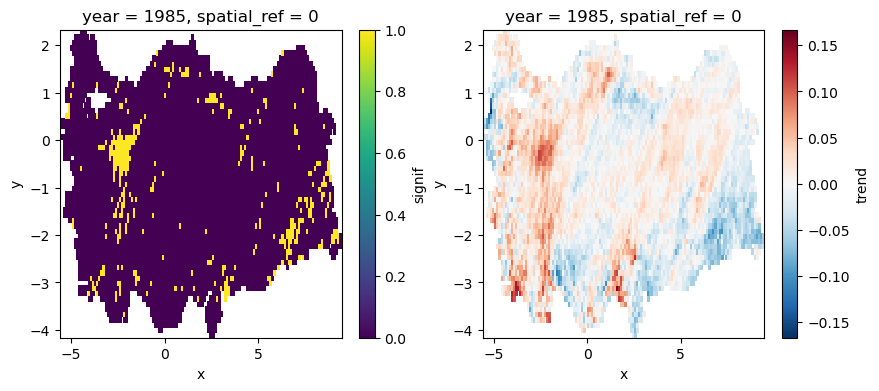

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

intensity_idx_trend.signif.plot(ax=ax[0])
intensity_idx_trend.trend.plot(ax=ax[1])

In [9]:
# save
intensity_idx_trend.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_trendMK_{intensity_indice_name}_198501_200512.nc")

## 3. Frequency Indices

### 3.1 Open Data

#### 3.1.1 Percentile

In [16]:
percentile_indice_name = fr'R{time_resample}hr0.95P'
percentile_idx_cosmo = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{percentile_indice_name}_198501_200512.nc")[name_variable_cosmo]

In [17]:
percentile_idx_cosmo

<xarray.DataArray 'TOT_PREC' (year: 21, rlat: 59, rlon: 137)>
[169743 values with dtype=int64]
Coordinates:
    lon       (rlat, rlon) float32 ...
    lat       (rlat, rlon) float32 ...
  * rlon      (rlon) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * rlat      (rlat) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    quantile  float64 ...
  * year      (year) int64 1985 1986 1987 1988 1989 ... 2001 2002 2003 2004 2005
Attributes:
    computation:  calculated 0.95 grouped by year and count above 0.95 over t...
    indice_name:  R1hr0.95P

In [18]:
# calculate trend
percentile_idx_trend = xarrayMannKendall.Mann_Kendall_test(percentile_idx_cosmo, alpha=0.05,
                                                    coords_name = {'time':'year','y':'rlat','x':'rlon'},
                                                    method='linregress', 
                                                    MK_modified=False).compute()

percentile_idx_trend = percentile_idx_trend.where(turkey_bool['TOT_PREC']==1)

In [19]:
percentile_idx_trend

<xarray.Dataset>
Dimensions:      (y: 59, x: 137)
Coordinates:
  * x            (x) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * y            (y) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    lon          (y, x) float32 ...
    lat          (y, x) float32 ...
    year         int64 ...
    spatial_ref  int64 ...
Data variables:
    trend        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    signif       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    p            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    std_error    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

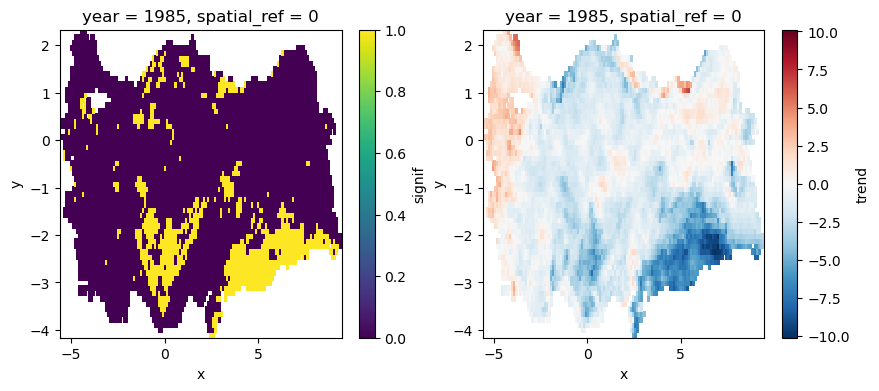

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

percentile_idx_trend.signif.plot(ax=ax[0])
percentile_idx_trend.trend.plot(ax=ax[1])

In [15]:
# save
percentile_idx_trend.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_trendMK_{percentile_indice_name}_198501_200512.nc")

#### 3.1.2 Absolute

In [21]:
# indice name
absolute_indice_name = fr'R{time_resample}hr{heavy_rain}mm'
absolute_idx_cosmo = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{absolute_indice_name}_198501_200512.nc")[name_variable_cosmo]

In [22]:
absolute_idx_cosmo

<xarray.DataArray 'TOT_PREC' (year: 21, rlat: 59, rlon: 137)>
[169743 values with dtype=int64]
Coordinates:
    lon      (rlat, rlon) float32 ...
    lat      (rlat, rlon) float32 ...
  * rlon     (rlon) float32 -5.55 -5.44 -5.33 -5.22 -5.11 ... 9.08 9.19 9.3 9.41
  * rlat     (rlat) float32 -4.11 -4.0 -3.89 -3.78 -3.67 ... 1.94 2.05 2.16 2.27
  * year     (year) int64 1985 1986 1987 1988 1989 ... 2001 2002 2003 2004 2005
Attributes:
    computation:  grouped by year and count above 4mm over time dimension
    indice_name:  R1hr4mm

In [23]:
# calculate trend
absolute_idx_trend = xarrayMannKendall.Mann_Kendall_test(absolute_idx_cosmo, alpha=0.05,
                                                    coords_name = {'time':'year','y':'rlat','x':'rlon'},
                                                    method='linregress', 
                                                    MK_modified=False).compute()

absolute_idx_trend = absolute_idx_trend.where(turkey_bool['TOT_PREC']==1)

In [24]:
absolute_idx_trend

<xarray.Dataset>
Dimensions:      (y: 59, x: 137)
Coordinates:
  * x            (x) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * y            (y) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    lon          (y, x) float32 ...
    lat          (y, x) float32 ...
    year         int64 ...
    spatial_ref  int64 ...
Data variables:
    trend        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    signif       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    p            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    std_error    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

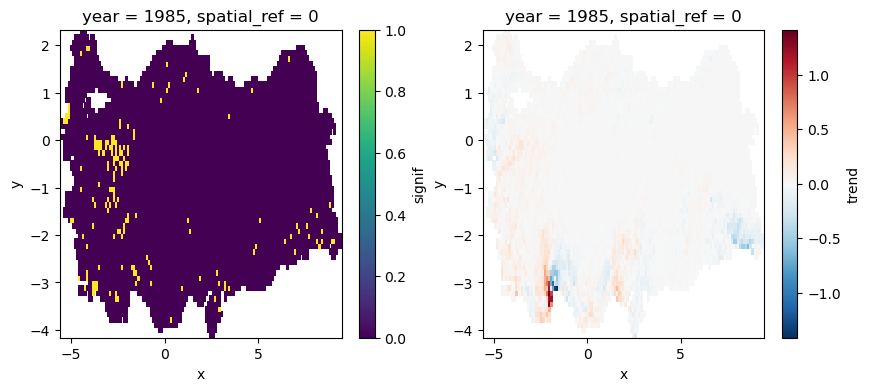

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

absolute_idx_trend.signif.plot(ax=ax[0])
absolute_idx_trend.trend.plot(ax=ax[1])

In [21]:
# save
absolute_idx_trend.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_trendMK_{absolute_indice_name}_198501_200512.nc")

## 4. Persistence Indices

### 4.1 Open Data

#### 4.1.1 Percentile

In [26]:
percentile_indice_name = fr'M{time_resample}hrCW0.95P'
percentile_idx_cosmo = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{percentile_indice_name}_198501_200512.nc")[name_variable_cosmo]

In [27]:
percentile_idx_cosmo

<xarray.DataArray 'TOT_PREC' (year: 21, rlat: 59, rlon: 137)>
[169743 values with dtype=float64]
Coordinates:
    lon       (rlat, rlon) float32 ...
    lat       (rlat, rlon) float32 ...
  * rlon      (rlon) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * rlat      (rlat) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    quantile  float64 ...
  * year      (year) int64 1985 1986 1987 1988 1989 ... 2001 2002 2003 2004 2005
Attributes:
    computation:  calculated 0.95 grouped by year and found maximum number of...
    indice_name:  M1hrCW0.95P

In [28]:
# calculate trend
percentile_idx_trend = xarrayMannKendall.Mann_Kendall_test(percentile_idx_cosmo, alpha=0.05,
                                                    coords_name = {'time':'year','y':'rlat','x':'rlon'},
                                                    method='linregress', 
                                                    MK_modified=False).compute()

percentile_idx_trend = percentile_idx_trend.where(turkey_bool['TOT_PREC']==1)

In [29]:
percentile_idx_trend

<xarray.Dataset>
Dimensions:      (y: 59, x: 137)
Coordinates:
  * x            (x) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * y            (y) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    lon          (y, x) float32 ...
    lat          (y, x) float32 ...
    year         int64 ...
    spatial_ref  int64 ...
Data variables:
    trend        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    signif       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    p            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    std_error    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

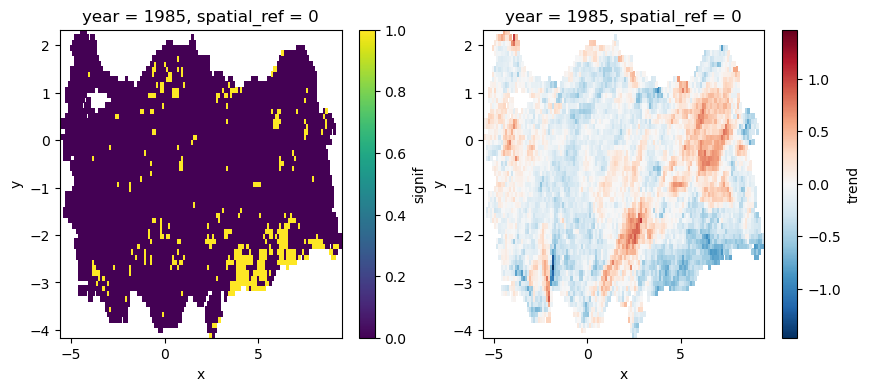

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

percentile_idx_trend.signif.plot(ax=ax[0])
percentile_idx_trend.trend.plot(ax=ax[1])

In [27]:
# save
percentile_idx_trend.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_trendMK_{percentile_indice_name}_198501_200512.nc")

#### 4.1.2 Absolute

In [31]:
# indice name
absolute_indice_name = fr'M{time_resample}hrCW{heavy_rain}mm'
absolute_idx_cosmo = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{absolute_indice_name}_198501_200512.nc")[name_variable_cosmo]

In [32]:
absolute_idx_cosmo

<xarray.DataArray 'TOT_PREC' (year: 21, rlat: 59, rlon: 137)>
[169743 values with dtype=float64]
Coordinates:
    lon      (rlat, rlon) float32 ...
    lat      (rlat, rlon) float32 ...
  * rlon     (rlon) float32 -5.55 -5.44 -5.33 -5.22 -5.11 ... 9.08 9.19 9.3 9.41
  * rlat     (rlat) float32 -4.11 -4.0 -3.89 -3.78 -3.67 ... 1.94 2.05 2.16 2.27
  * year     (year) int64 1985 1986 1987 1988 1989 ... 2001 2002 2003 2004 2005
Attributes:
    computation:  grouped by year and found maximum number of consecutive tim...
    indice_name:  M1hrCW4mm

In [33]:
# calculate trend
absolute_idx_trend = xarrayMannKendall.Mann_Kendall_test(absolute_idx_cosmo, alpha=0.05,
                                                    coords_name = {'time':'year','y':'rlat','x':'rlon'},
                                                    method='linregress', 
                                                    MK_modified=False).compute()

absolute_idx_trend = absolute_idx_trend.where(turkey_bool['TOT_PREC']==1)

In [34]:
absolute_idx_trend

<xarray.Dataset>
Dimensions:      (y: 59, x: 137)
Coordinates:
  * x            (x) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * y            (y) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    lon          (y, x) float32 ...
    lat          (y, x) float32 ...
    year         int64 ...
    spatial_ref  int64 ...
Data variables:
    trend        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    signif       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    p            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    std_error    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

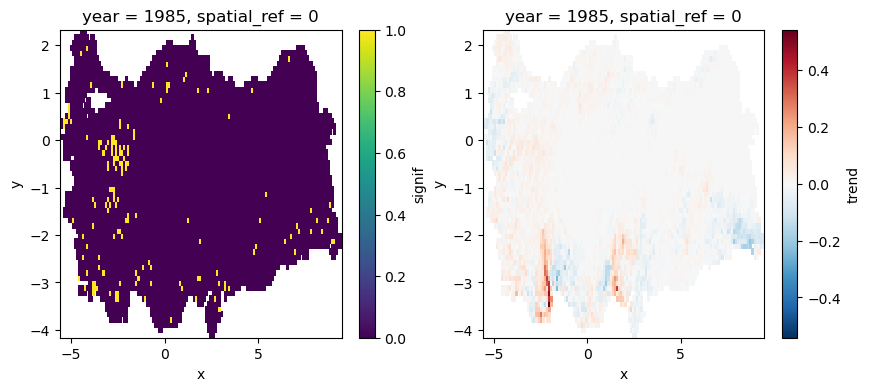

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

absolute_idx_trend.signif.plot(ax=ax[0])
absolute_idx_trend.trend.plot(ax=ax[1])

In [33]:
# save
absolute_idx_trend.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_trendMK_{absolute_indice_name}_198501_200512.nc")